<a href="https://colab.research.google.com/github/Chandravardhan02/Customer_churn_prediction/blob/main/Spotify_Customer_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preprocessing and Mock Feature Creation Complete.

--- Starting Churn Prediction ---
Churn Prediction Model F1-Score: 0.44
Churn Prediction Model ROC-AUC Score: 0.81


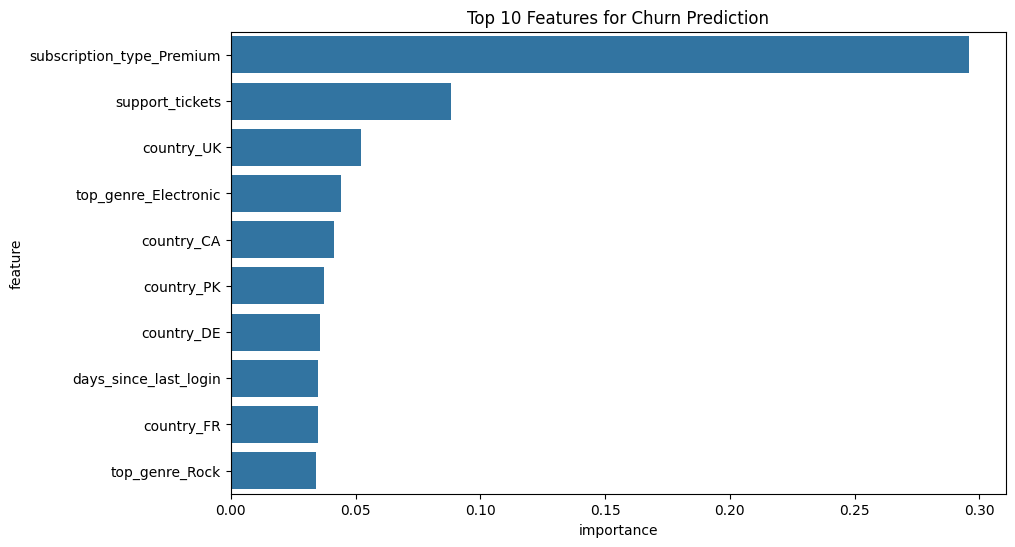


--- Starting Purchase Behavior Prediction ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Purchase Prediction Model Accuracy: 1.00
Purchase Prediction Model F1-Score: 0.00

--- Starting Customer Segmentation ---


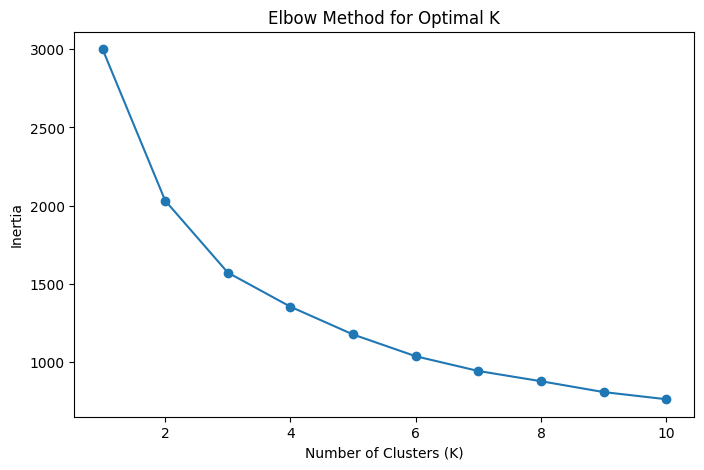

Customers segmented into 3 clusters.
Customer counts per cluster:
Cluster
0    378
2    325
1    297
Name: count, dtype: int64



--- Starting Customer Lifetime Value (CLV) Calculation ---
A simple CLV metric has been calculated.
Top 5 customers by estimated CLV:
    subscription_type  avg_daily_minutes  number_of_playlists     CLV
974           Premium              217.3                    9  1955.7
57            Premium              235.6                    7  1649.2
511           Premium              161.2                   10  1612.0
500           Premium              172.0                    9  1548.0
532           Premium              151.8                   10  1518.0

--- Final Predictions Summary ---
Out of 200 test customers:
 -> The model predicts 36 are likely to churn (18.00%).
 -> The model predicts 0 are likely to make a premium purchase (0.00%).

Final analysis complete.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, silhouette_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


df = pd.read_csv('spotify_churn_dataset.csv')
df = df.drop('user_id', axis=1)
df['Purchase'] = ((df['subscription_type'] == 'Premium') & (df['number_of_playlists'] > 10)).astype(int)
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop(['churned', 'Purchase'], axis=1)
y_churn = df_encoded['churned']
y_purchase = df_encoded['Purchase']
print("Data Preprocessing and Mock Feature Creation Complete.")
print("\n--- Starting Churn Prediction ---")


X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size=0.2, random_state=42)
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train_churn, y_train_churn)
y_pred_churn = model_xgb.predict(X_test_churn)
f1_churn = f1_score(y_test_churn, y_pred_churn)
roc_auc_churn = roc_auc_score(y_test_churn, model_xgb.predict_proba(X_test_churn)[:, 1])


print(f"Churn Prediction Model F1-Score: {f1_churn:.2f}")
print(f"Churn Prediction Model ROC-AUC Score: {roc_auc_churn:.2f}")


feature_importances = pd.DataFrame({'feature': X_train_churn.columns, 'importance': model_xgb.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features for Churn Prediction')
plt.show()


print("\n--- Starting Purchase Behavior Prediction ---")
X_train_purchase, X_test_purchase, y_train_purchase, y_test_purchase = train_test_split(X, y_purchase, test_size=0.2, random_state=42)


model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_purchase, y_train_purchase)
y_pred_purchase = model_rf.predict(X_test_purchase)
accuracy_purchase = accuracy_score(y_test_purchase, y_pred_purchase)
f1_purchase = f1_score(y_test_purchase, y_pred_purchase)


print(f"Purchase Prediction Model Accuracy: {accuracy_purchase:.2f}")
print(f"Purchase Prediction Model F1-Score: {f1_purchase:.2f}")


print("\n--- Starting Customer Segmentation ---")
features_for_clustering = ['avg_daily_minutes', 'number_of_playlists', 'skips_per_day']
X_clustering = df[features_for_clustering].copy()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)


inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


print(f"Customers segmented into {optimal_k} clusters.")
print("Customer counts per cluster:")
print(df['Cluster'].value_counts())


fig = px.scatter_3d(df, x='avg_daily_minutes', y='number_of_playlists', z='skips_per_day',
                    color=df['Cluster'].astype(str), opacity=0.8,
                    title='Customer Segments (Daily Minutes, Playlists & Skips)',
                    color_discrete_map={'0': 'blue', '1': 'red', '2': 'green'})
fig.show()


print("\n--- Starting Customer Lifetime Value (CLV) Calculation ---")
df['CLV'] = df['avg_daily_minutes'] * df['number_of_playlists']


print("A simple CLV metric has been calculated.")
print("Top 5 customers by estimated CLV:")
print(df[['subscription_type', 'avg_daily_minutes', 'number_of_playlists', 'CLV']].sort_values(by='CLV', ascending=False).head())


print("\n--- Final Predictions Summary ---")
predicted_churners = np.sum(y_pred_churn)
total_test_customers_churn = len(y_test_churn)
churn_percentage = (predicted_churners / total_test_customers_churn) * 100


print(f"Out of {total_test_customers_churn} test customers:")
print(f" -> The model predicts {predicted_churners} are likely to churn ({churn_percentage:.2f}%).")
predicted_purchasers = np.sum(y_pred_purchase)
total_test_customers_purchase = len(y_test_purchase)
purchase_percentage = (predicted_purchasers / total_test_customers_purchase) * 100


print(f" -> The model predicts {predicted_purchasers} are likely to make a premium purchase ({purchase_percentage:.2f}%).")


print("\nFinal analysis complete.")
